# A2: Module 2 

For this module you will work with k-space data (Fourier space data) from MRI – and deal with a few common artifacts. The data contains a 3D knee image with six coil receivers.

### Exercise 2.1 Visualisation and identifying noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


Dimension 0 showing coils

In [2]:
kspace= np.load("kspace.npy")
print(f"the file has dimensions of {kspace.shape}, and the coil dimension is {kspace.shape[0]} which is the 0th array dimension")

the file has dimensions of (6, 280, 280), and the coil dimension is 6 which is the 0th array dimension


Plotting each coil in k-space

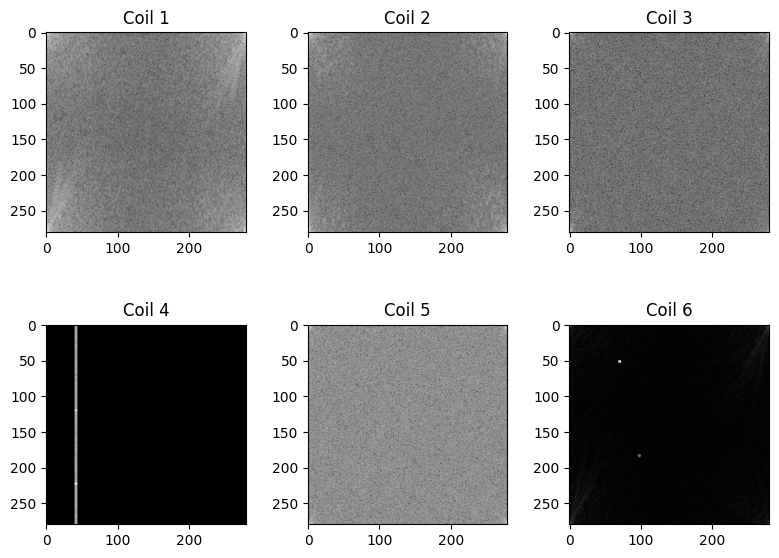

In [3]:
fig, ax = plt.subplots(2,3,figsize=(8,6))
ax = ax.flatten() #instead of acessing with ax[2,3], it will be ax[6]
plt.tight_layout()

#instead of unpacking all three dimensions, use coil as an index
coils = range(kspace.shape[0])
for coil in coils:
    image = np.abs(kspace[coil,:,:])
    ax[coil].imshow(np.log1p(image),cmap="gray")
    ax[coil].set_title(f"Coil {coil+1}")


    

tranpose the data into image space using fourier transform. This is the images for magnitude and phase for first coil (coil 0)

Text(0.5, 1.0, 'Image-space: Phase image')

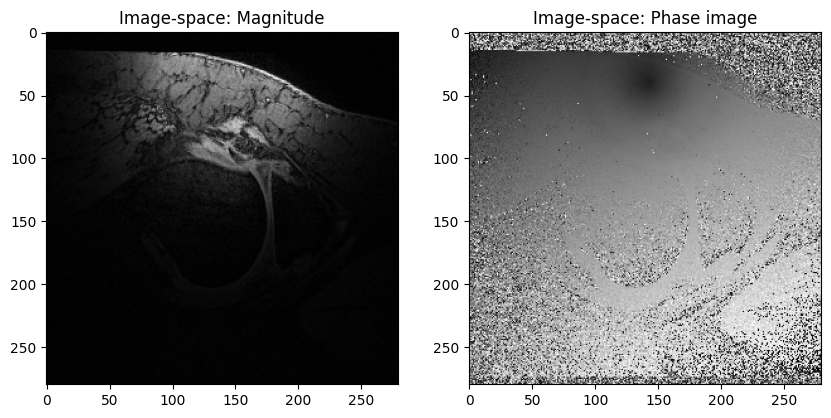

In [4]:
image=np.fft.ifft2(kspace)
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(np.abs(image[0,:,:]),cmap='gray')
ax[0].set_title('Image-space: Magnitude')
ax[1].imshow(np.angle(image[0,:,:]), cmap='gray')
ax[1].set_title('Image-space: Phase image')

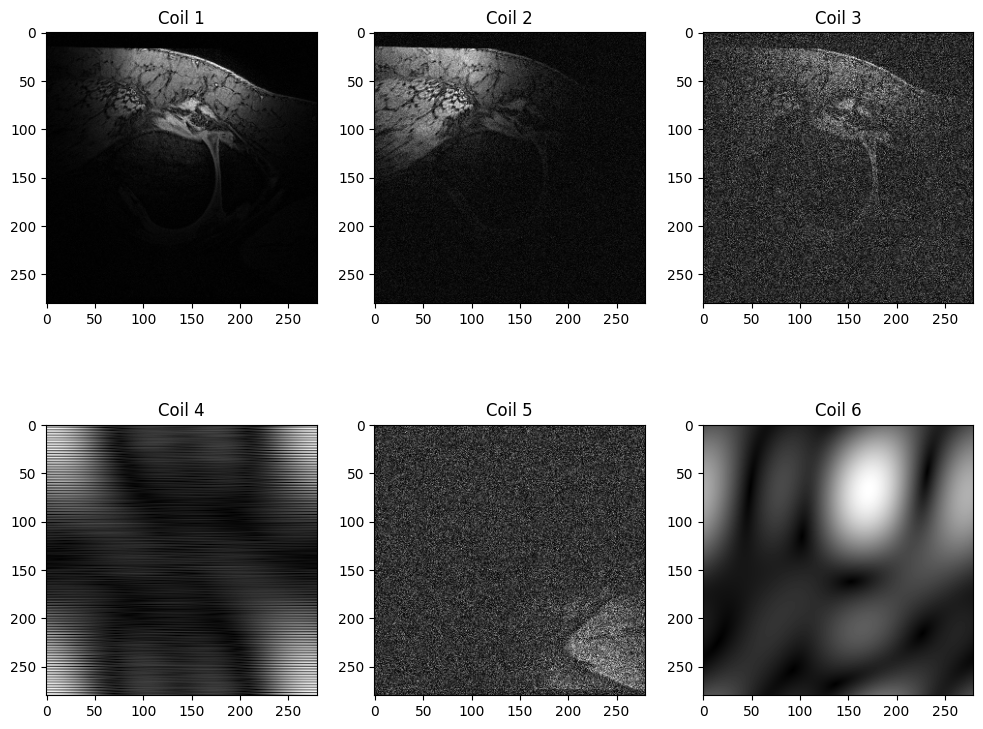

In [5]:
fig, ax = plt.subplots(2,3,figsize=(10,8))
ax = ax.flatten()
plt.tight_layout()

for coil in coils:
    index=coil
    ax[index].imshow(np.abs(image[coil,:,:]),cmap="gray")#magnitude
    ax[index].set_title(f"Coil {coil+1}")

#magnitude images being used nearly exclusively for diagnosis. Phase-images are occasionally generated in clinical MRI for the depiction of flow and characterization of susceptibility-induced distortions.
#https://mriquestions.com/real-v-imaginary.html#:~:text=Imaginary-,Magnitude,characterization%20of%20susceptibility%2Dinduced%20distortions.

Text(0.5, 1.0, 'Combined images from 6 coils')

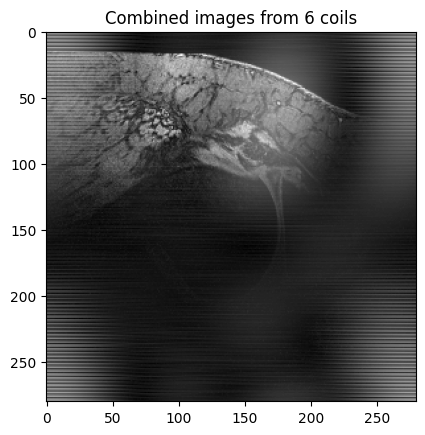

In [6]:
summed_image = np.zeros((image.shape[1],image.shape[2]),dtype='float64')
for coil in coils:
    summed_image += (np.abs(image[coil,:,:]))**2
final_image = np.sqrt(summed_image)

plt.imshow(final_image,cmap="gray")
plt.title("Combined images from 6 coils")

### Ex2.2 Removing Noise 
Choose three denoising methods using the image space data, and show the effects
of the denoising for all coils. Denoising methods can include mean, bilateral,
wavelet, or any other filter. A number of filters can be found in scikit-image. "gaussian_filter" can be found in scipy.ndimage. Comment on the different
denoising methods.

### Bilateral filter
1. Bilateral filter: A bilateral filter is an edge-preserving and noise reducing filter. It averages pixels based on their spatial closeness and radiometric similarity. (https://scikit-image.org/docs/0.23.x/auto_examples/filters/plot_denoise.html)

In [7]:
import cv2
from scipy.ndimage import convolve
from scipy import ndimage
from skimage.filters import butterworth

In [8]:
def mean_filter(img,kernel_size=3): #I can look at different kernel sizes
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size * kernel_size)
    return convolve(img,kernel)

def gaussian_filtering(img,sigma=1): #I can look at different standard deviations of a gaussian.(sigma)
    return ndimage.gaussian_filter(img, sigma=sigma)

def bilateral_filtering(img, d=9, sigma_color=75, sigma_space=75): 
    # d = Diameter of each pixel neighborhood that is used during filtering
    # sigma_color = pixels with similar intensity values will have higher weight in the kernel.
                    # e.g. large sigma_color means a larger range of intensities will be blurred together.
                    # basically it is a tradeoff between noise reduction, but also losing some sharp edges in image.
    # sigma_space = Controls how much weight is assigned to pixels within d based on distance from the center pixel.
    return cv2.bilateralFilter(img.astype(np.float32), d, sigma_color, sigma_space)
#keeping edges sharp while removing noise, because i am applying 2 gaussian filters, one for considering the space (depending on kernel size,) and pixel difference (only blurring similar pixel intensity values that is mostly due to noise.)

### Mean Filter

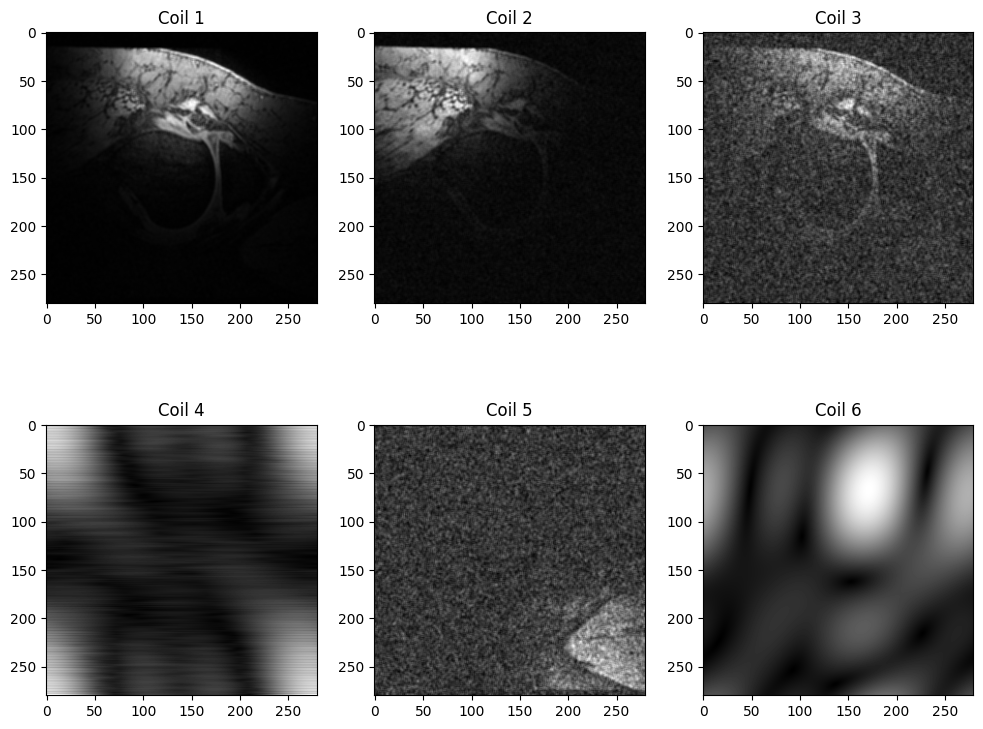

In [9]:
fig, ax = plt.subplots(2,3,figsize=(10,8))
ax = ax.flatten()
plt.tight_layout()

for coil in coils:
    ax[coil].imshow(mean_filter(np.abs(image[coil,:,:]),kernel_size=3),cmap="gray")
    ax[coil].set_title(f"Coil {coil+1}")

### Gaussian Filter

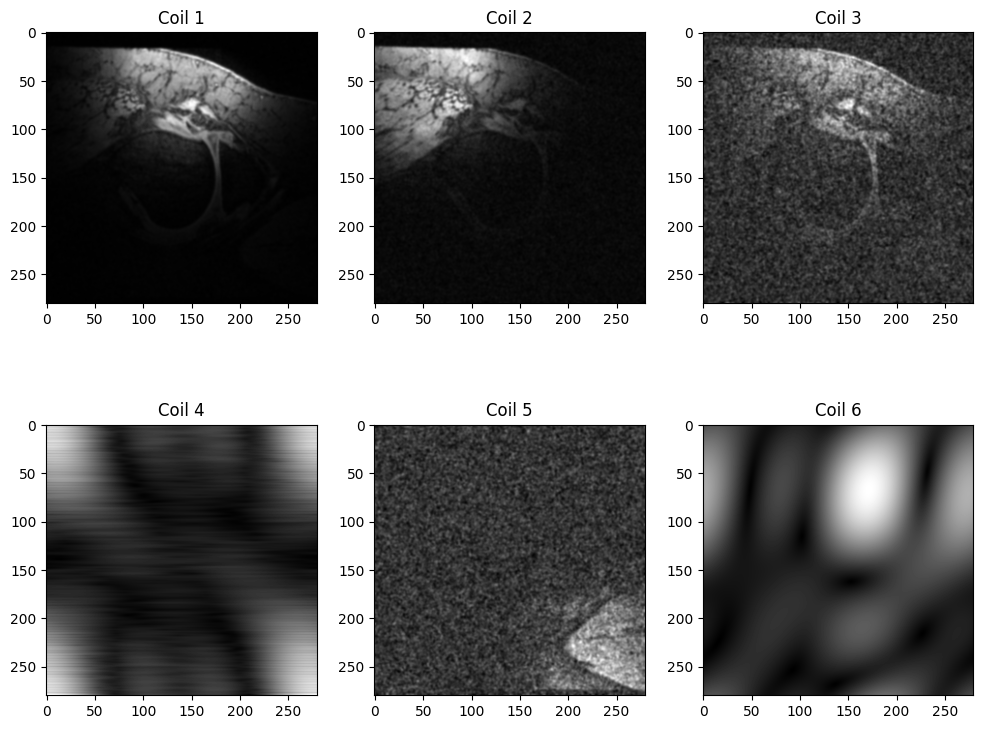

In [10]:
fig, ax = plt.subplots(2,3,figsize=(10,8))
ax = ax.flatten()
plt.tight_layout()

for coil in coils:
    ax[coil].imshow(gaussian_filtering(np.abs(image[coil,:,:]),sigma=1),cmap="gray")
    ax[coil].set_title(f"Coil {coil+1}")
    
#The Gaussian kernel will have size 2*radius + 1 along each axis. If radius is None, the default radius = round(truncate * sigma) will be used.
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html

### Bilateral filter

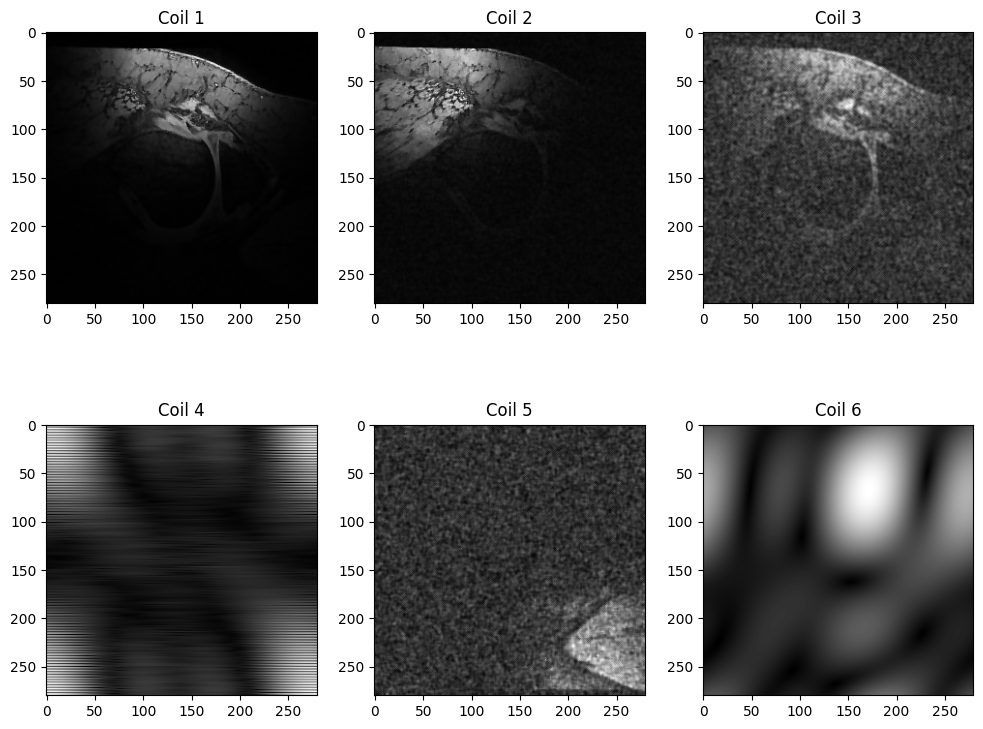

In [11]:
fig, ax = plt.subplots(2,3,figsize=(10,8))
ax = ax.flatten()
plt.tight_layout()

for coil in coils:
    ax[coil].imshow(bilateral_filtering(np.abs(image[coil,:,:]),d=5, sigma_color=10, sigma_space=5),cmap="gray")
    ax[coil].set_title(f"Coil {coil+1}")

• Start from the original noisy k-space. For the first coil, apply a low-pass
Butterworth filter within k-space and show the new image, showing both
magnitude and phase images. How does this denoising method compare to the
image-based methods?

smoothing process but it generates lesser ringing effect 

Butterworth  filter: Butterworth is type of low pass filter that allows low frequency components, and dropping the high frequncy components of the images.It is used to smoothing the images, and reduce the noise with enchancing the details of the images.
https://sumitkrsharma-ai.medium.com/butterworth-low-pass-filter-in-image-pre-processing-7772ee9c9c46

Text(0.5, 1.0, 'Phase')

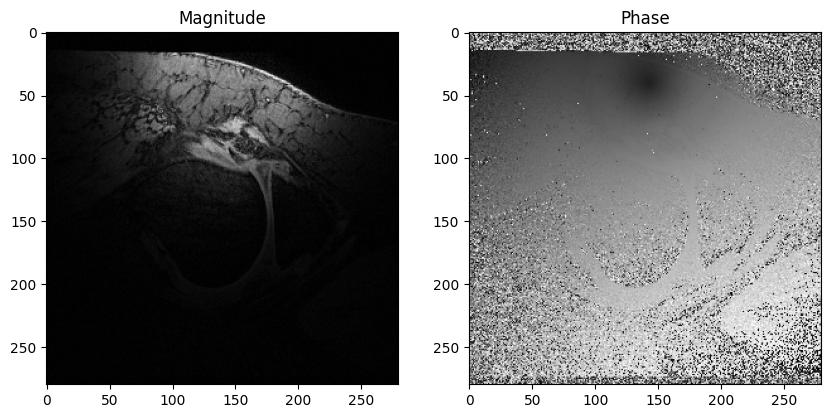

In [12]:
#butterworth is a filter from scikit-image, and it is defined in the Fourier domain (k-space, or where everything is just in waves not an image)

butter_kspace= butterworth(kspace[0,:,:])
butter_image=np.fft.ifft2(butter_kspace)
butter_mag = np.abs(butter_image)
butter_phase = np.angle(butter_image)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(butter_mag,cmap="gray")
ax[0].set_title("Magnitude")
ax[1].imshow(butter_phase,cmap="gray")
ax[1].set_title("Phase")

#oh my god i didnt know that there is the butterworth code in the next page. i will try it now. in the next chunk.


Text(0.5, 1.0, 'Phase')

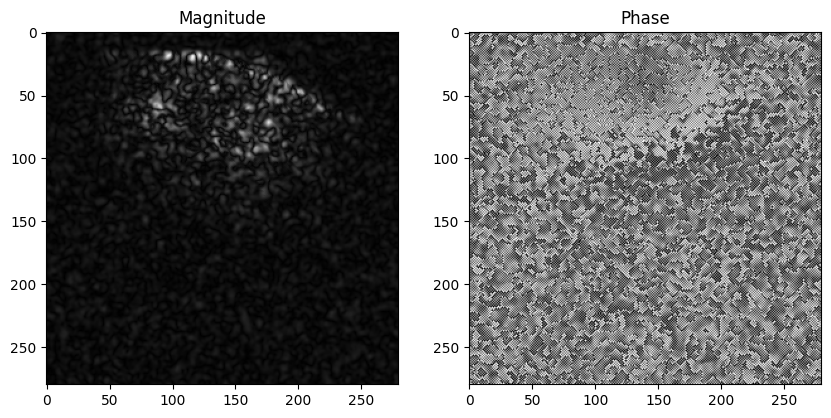

In [13]:
def butterworth_lowpass_filter(shape, D0=30, n=2):
    P, Q = shape[0], shape[1] #extract kspace[0] and kspace[1] given that it is just one coil
    u = np.arange(P) - P // 2 #since P is 280, then np.arange will give intergers from 0 to 279. then minus 140. so, u is values between -140 to 130.
    v = np.arange(Q) - Q // 2 #same
    U, V = np.meshgrid(u, v, indexing='ij') #make a mesh grid of values 
    D = np.sqrt(U**2 + V**2)  #Distance Matrix: how far is each frequency is from the low frequency region?
    H = 1 / (1 + (D / D0) ** (2 * n)) #Frequency above D0 will be cut off.
    return H #return the mask

kspace_altered=kspace[0,:,:]
bw_mask=butterworth_lowpass_filter(kspace_altered.shape,D0=30, n=2)
bw=bw_mask * kspace[0]
bw_image=np.fft.ifft2(bw)
bw_mag = np.abs(bw_image)
bw_phase = np.angle(bw_image)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(bw_mag,cmap="gray")
ax[0].set_title("Magnitude")
ax[1].imshow(bw_phase,cmap="gray")
ax[1].set_title("Phase")

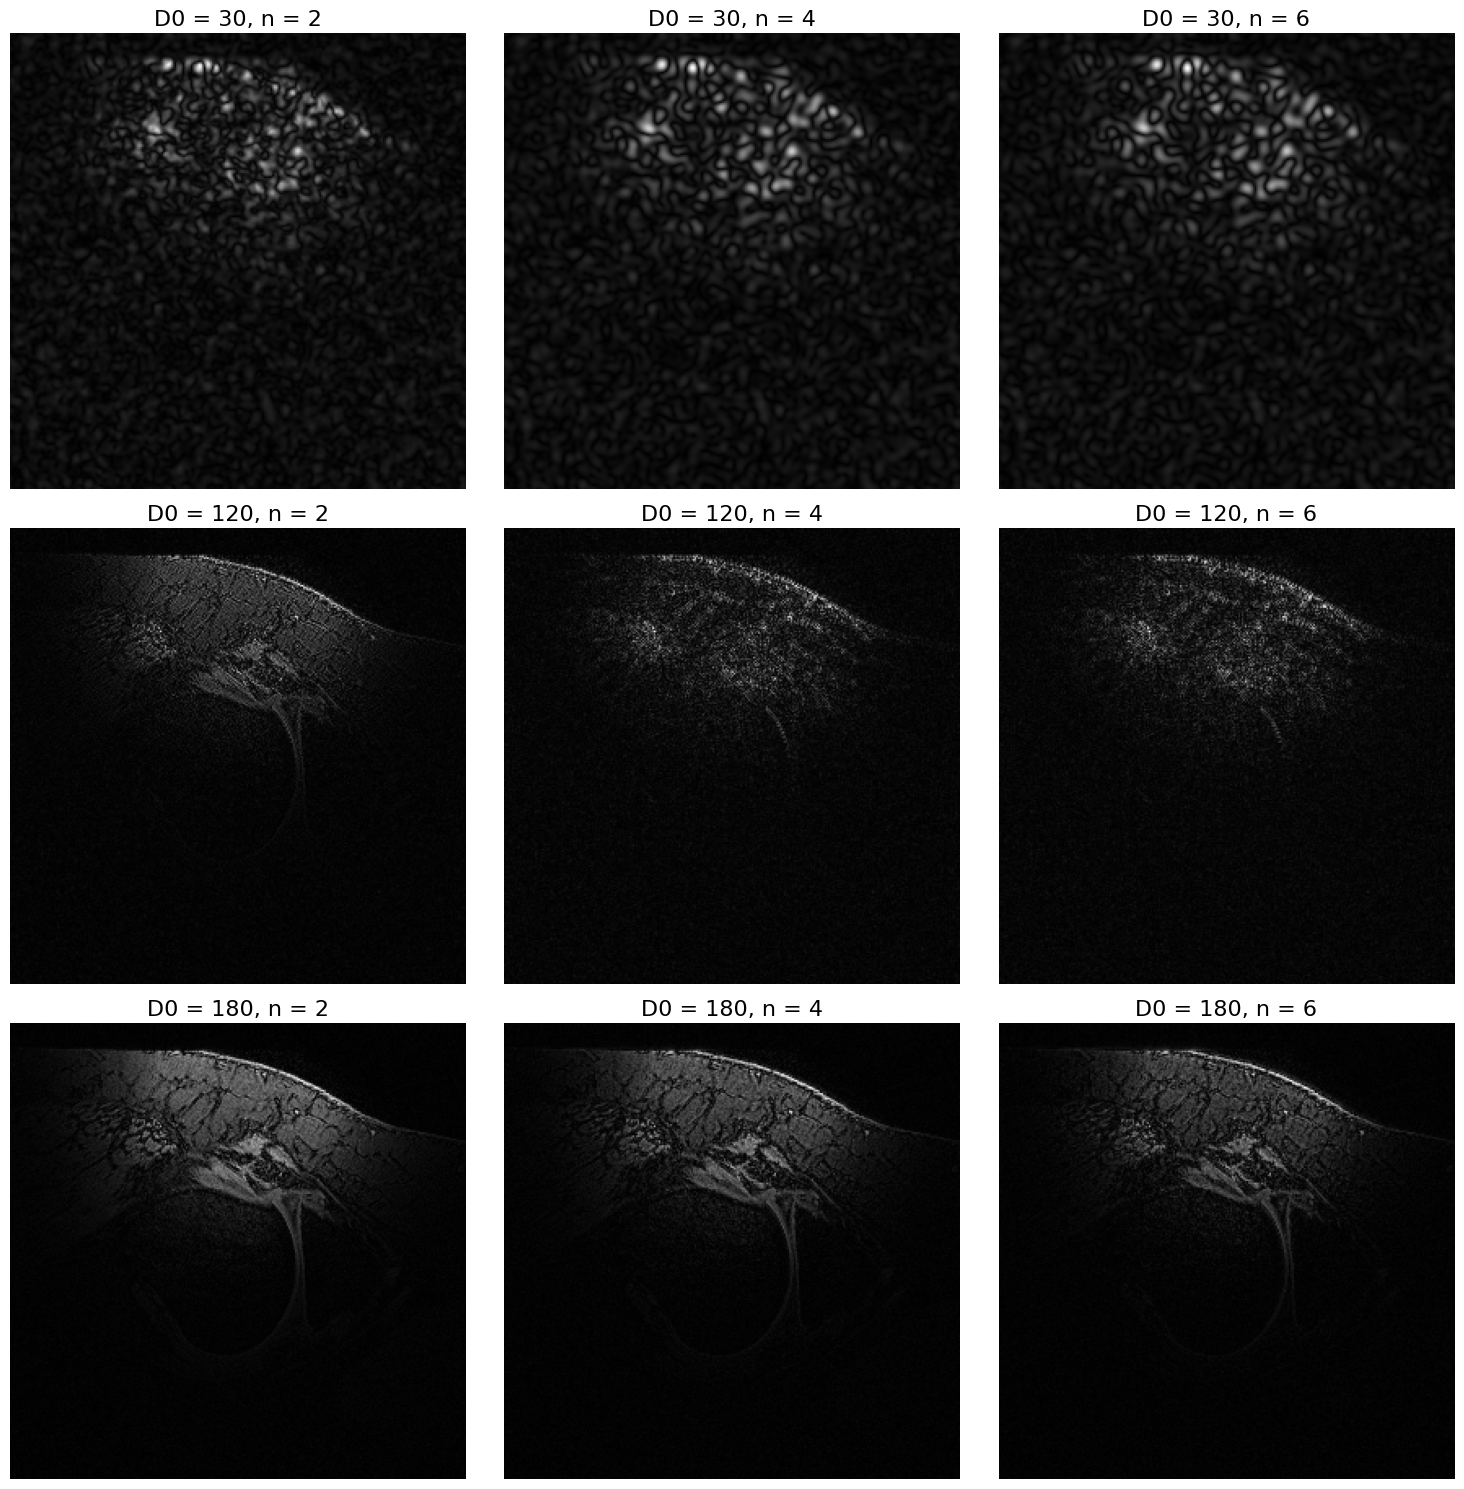

In [14]:
# Define D0 and n values for experiments
d0_values = [30, 120, 180]
n_values = [2, 4, 6]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, d0 in enumerate(d0_values):
    for j, n in enumerate(n_values):
        kspace_altered = kspace[0,:,:]
        bw_mask = butterworth_lowpass_filter(kspace_altered.shape, D0=d0, n=n)
        bw = bw_mask * kspace[0]
        bw_image = np.fft.ifft2(bw)
        bw_mag = np.abs(bw_image)
        
        axes[i, j].imshow(bw_mag, cmap="gray")
        axes[i, j].set_title(f"D0 = {d0}, n = {n}",fontsize=16)
        axes[i, j].axis('off') 

plt.tight_layout()
plt.show()

Creating a combined image using mean filtering: 

Text(0.5, 1.0, 'Combined image (with mean filter)')

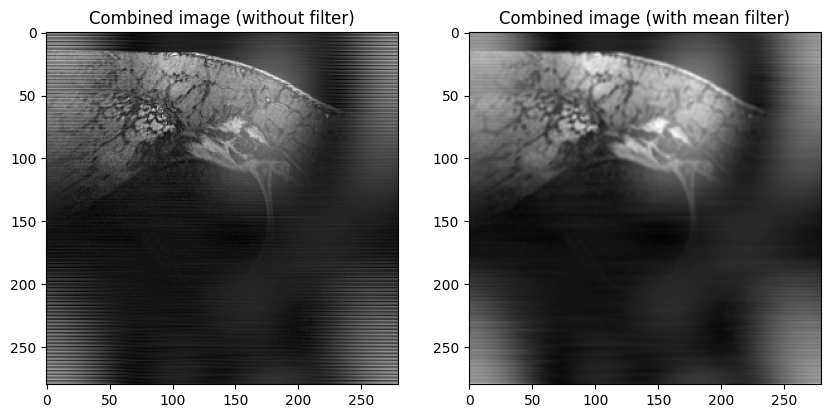

In [15]:

summed_mean_img = np.zeros((image.shape[1],image.shape[2]),dtype='float64')
for coil in coils:
    summed_mean_img += mean_filter(np.abs(image[coil,:,:]),kernel_size=3)**2
final_mean_img = np.sqrt(summed_mean_img)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(final_image,cmap="gray")
ax[0].set_title("Combined image (without filter)")
ax[1].imshow(final_mean_img,cmap="gray")
ax[1].set_title("Combined image (with mean filter)")
